# Regression of pH range using machine learning (Random Forest)

In [1]:
HOME_DIR = '/Users/datatranslators/Documents/GitHub/acido_CEST_Machine_Learning/'
DESTINATION = 'outputs'

## Libraries

In [2]:
#libs
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
import pandas as pd
import numpy as np
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn import metrics

from sklearn.pipeline import Pipeline
from sklearn import preprocessing as pp
import seaborn as sns

from sklearn.feature_selection import SelectFromModel

from joblib import dump, load

## Data

In [3]:
# load data
acidoCEST_ML = pd.read_parquet('../clean_data/acido_CEST_MRI_Iopamidol.parquet.gzip')

# drop columns we cannot measure or that are redundant
cols_2_drop = ['ApproT1(sec)','Temp','ExpB0(ppm)','FILE','Conc(mM)']
acidoCEST_ML = acidoCEST_ML.drop(cols_2_drop, axis = 1)

# define experimental columns -- > things we measure other than CEST
exper_cols = [ 'ExpB1(percent)', 'ExpB0(Hz)', 'SatPower(uT)',  'SatTime(ms)','ExpT1(ms)', 'ExpT2(ms)']

# used during development
#acidoCEST_ML  = acidoCEST_ML.sample( n = 5_00)

acidoCEST_ML.shape

(20000, 88)

## Functions

### Random Forest

In [4]:
# Regression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor as RFR

def train_RFR(Xdata, pH_observed):
    print('------------------ Random Forest ------------------ ')
    print()
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(Xdata, pH_observed, test_size=0.30, random_state=42)
        
        
    
    max_f = int( 0.5 * Xdata.shape[1] )
        
    # Regression
    #param_grid = dict( n_estimators = [100,200,500], max_depth =[None], max_features=['sqrt','log2','auto',max_f], max_samples=[.10,.50], min_samples_leaf=[.01,.50] )

    
    param_grid = dict( n_estimators = [100,200,500], max_depth =[10,20,40,None] )

    
    # grid parameters
    scorer = metrics.make_scorer( metrics.r2_score, greater_is_better = True) 
    
    #
    estimator = GridSearchCV( RFR(random_state = 42,  n_jobs = -1), param_grid, verbose = 3, cv = 3, n_jobs= 1, scoring=scorer )

    # fit
    estimator.fit(X_train, y_train)

    score_train = np.round( 100 * metrics.mean_absolute_percentage_error(y_train , estimator.predict(X_train)), 2)
    score_test  = np.round( 100 * metrics.mean_absolute_percentage_error(y_test , estimator.predict(X_test)), 2)

    #score on pH units
    score_pH_train = np.mean( np.abs(  y_train -  estimator.predict(X_train) ) )
    score_pH_test = np.mean( np.abs(  y_test -  estimator.predict(X_test) ) )


    m = f' mean absolute percentage error \n train = {score_train} % \n test  = {score_test} %'
    m2 = f'\n pH units |error : \ntrain = {score_pH_train:.3f} \n test = {score_pH_test:.3f}'
    
    #print(', '.join(Xdata.columns.to_list()))
    print()
    print(m,'\n',m2,'\n')
   
    plt.figure()
    sns.regplot(x = estimator.best_estimator_.predict(X_train), y =  y_train)
    plt.xlabel('\n Predicted pH')
    plt.ylabel('Measured pH \n')
    plt.title('Train Random Forest')
    
    plt.figure()
    sns.regplot(x = estimator.best_estimator_.predict(X_test), y =  y_test)
    plt.xlabel('\n Predicted pH')
    plt.ylabel('Measured pH \n')
    plt.title('Test Random Forest')
    
    print(estimator.best_estimator_)
    
    scores = dict()
    scores['mae_train'] = score_train
    scores['mae_test'] = score_test
    scores['pH_train'] = score_pH_train
    scores['pH_test'] = score_pH_test
    
    test_data = dict()
    test_data['X'] = X_test
    test_data['Y'] = y_test
    
    return estimator.best_estimator_, scores, test_data

def save_and_print(RFO, name='foo'):
    print('-----')
    for k in RFO.get_params().keys():
        print(f'{k}: {RFO.get_params()[k]}')
    
    dump(RFO, HOME_DIR + DESTINATION + f'/{name}.joblib') 

# Results

## Random Forest

### 4.2 and 5.6 only

------------------ Random Forest ------------------ 

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END ....max_depth=10, n_estimators=100;, score=0.234 total time=   1.5s
[CV 2/3] END ....max_depth=10, n_estimators=100;, score=0.225 total time=   0.2s
[CV 3/3] END ....max_depth=10, n_estimators=100;, score=0.235 total time=   0.2s
[CV 1/3] END ....max_depth=10, n_estimators=200;, score=0.235 total time=   0.3s
[CV 2/3] END ....max_depth=10, n_estimators=200;, score=0.226 total time=   0.4s
[CV 3/3] END ....max_depth=10, n_estimators=200;, score=0.235 total time=   0.4s
[CV 1/3] END ....max_depth=10, n_estimators=500;, score=0.234 total time=   0.8s
[CV 2/3] END ....max_depth=10, n_estimators=500;, score=0.226 total time=   0.8s
[CV 3/3] END ....max_depth=10, n_estimators=500;, score=0.233 total time=   0.8s
[CV 1/3] END ....max_depth=20, n_estimators=100;, score=0.145 total time=   0.3s
[CV 2/3] END ....max_depth=20, n_estimators=100;, score=0.138 total time=  

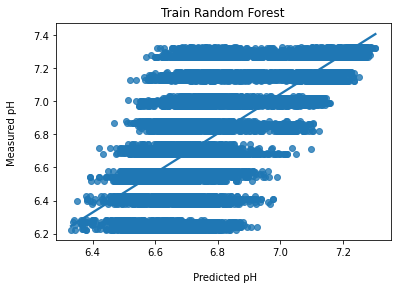

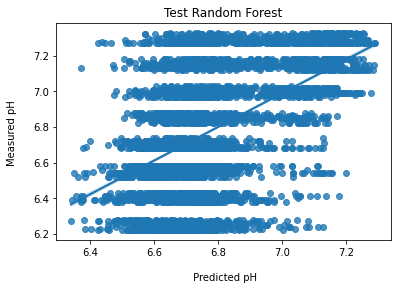

In [5]:
%%time

Xdata = acidoCEST_ML[['4.2','5.6']]
Y     = acidoCEST_ML.pH

reg_rf, _, _ = train_RFR(Xdata,Y)

save_and_print(reg_rf, name='RF_regressor_4256')

#### Feature Importance

Text(0.5, 1.0, 'Feature Importance for Regression of pH \n Only CEST features were used\n')

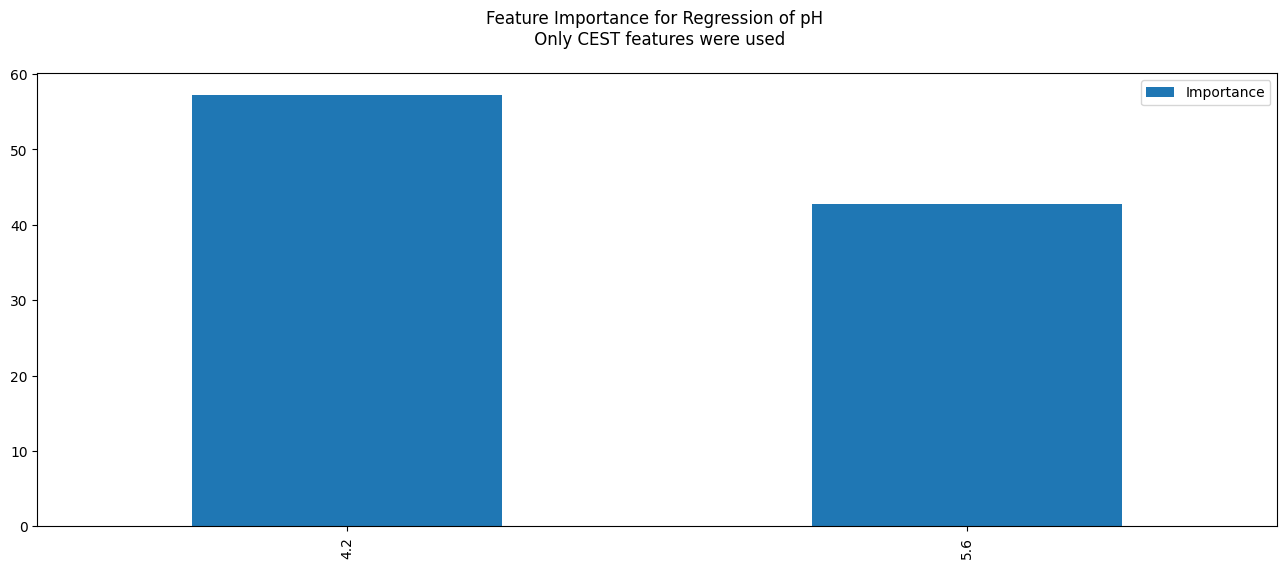

In [6]:
I = pd.DataFrame( 100 * reg_rf.feature_importances_, columns=['Importance'], index = Xdata.columns)
_, ax = plt.subplots(dpi = 100, figsize=(16,6))
I.plot(kind='bar', ax = ax, rot=90)
plt.title('Feature Importance for Regression of pH \n Only CEST features were used\n')

### Only CEST data

------------------ Random Forest ------------------ 

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END ....max_depth=10, n_estimators=100;, score=0.607 total time=   4.6s
[CV 2/3] END ....max_depth=10, n_estimators=100;, score=0.603 total time=   4.7s
[CV 3/3] END ....max_depth=10, n_estimators=100;, score=0.594 total time=   4.8s
[CV 1/3] END ....max_depth=10, n_estimators=200;, score=0.606 total time=   9.5s
[CV 2/3] END ....max_depth=10, n_estimators=200;, score=0.604 total time=   9.6s
[CV 3/3] END ....max_depth=10, n_estimators=200;, score=0.595 total time=   9.4s
[CV 1/3] END ....max_depth=10, n_estimators=500;, score=0.607 total time=  22.2s
[CV 2/3] END ....max_depth=10, n_estimators=500;, score=0.605 total time=  21.1s
[CV 3/3] END ....max_depth=10, n_estimators=500;, score=0.597 total time=  21.3s
[CV 1/3] END ....max_depth=20, n_estimators=100;, score=0.660 total time=   6.1s
[CV 2/3] END ....max_depth=20, n_estimators=100;, score=0.661 total time=  

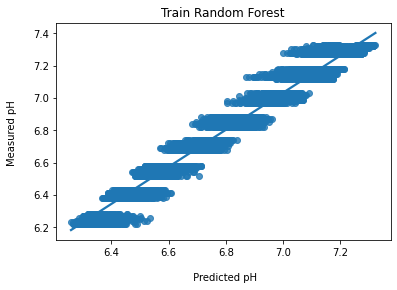

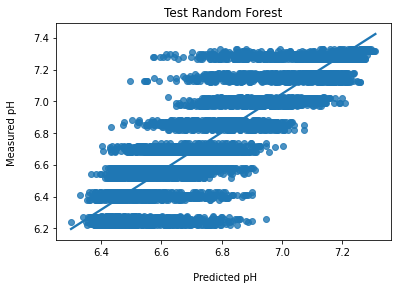

In [7]:
%%time

Xdata = acidoCEST_ML.drop(exper_cols + ['pH'],axis=1)
Ydata = acidoCEST_ML.pH 

reg_rf_only_CEST, _, _  = train_RFR(Xdata,Ydata)
save_and_print(reg_rf_only_CEST, name='RF_regressor_all_CEST')

#### Feature Importance

Text(0.5, 1.0, 'Feature Importance for Regression of pH \n Only CEST features were used\n')

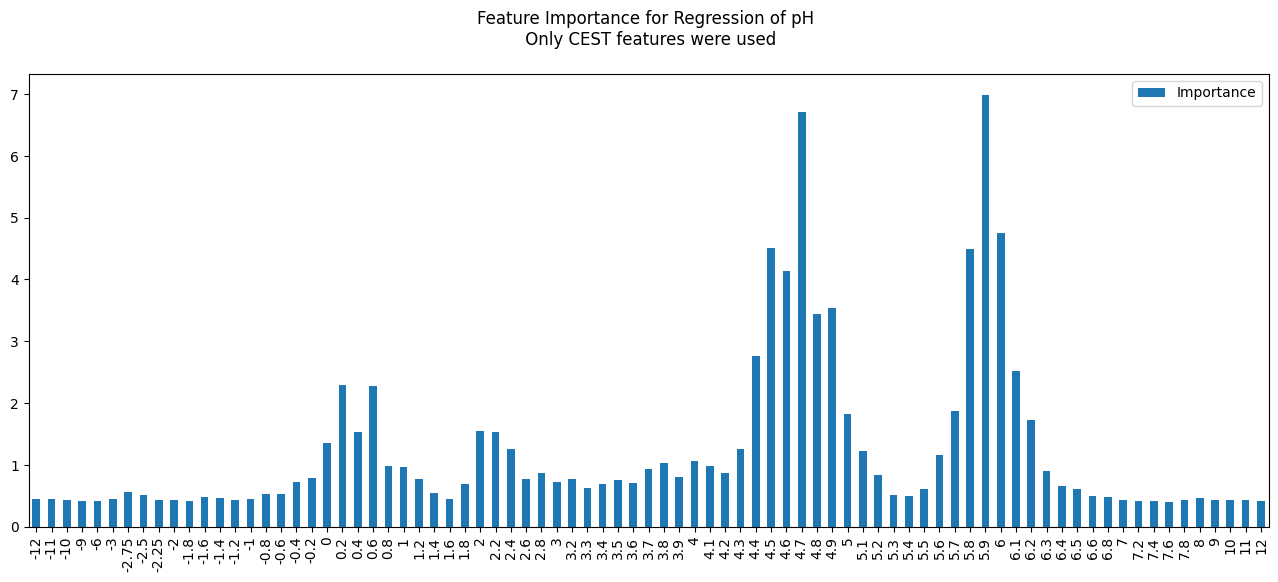

In [8]:
I = pd.DataFrame( 100 * reg_rf_only_CEST.feature_importances_, columns=['Importance'], index = Xdata.columns)
_, ax = plt.subplots(dpi = 100, figsize=(16,6))
I.plot(kind='bar', ax = ax, rot=90)
plt.title('Feature Importance for Regression of pH \n Only CEST features were used\n')

### All data

------------------ Random Forest ------------------ 

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END ....max_depth=10, n_estimators=100;, score=0.748 total time=   4.4s
[CV 2/3] END ....max_depth=10, n_estimators=100;, score=0.761 total time=   4.6s
[CV 3/3] END ....max_depth=10, n_estimators=100;, score=0.764 total time=   4.8s
[CV 1/3] END ....max_depth=10, n_estimators=200;, score=0.748 total time=   9.2s
[CV 2/3] END ....max_depth=10, n_estimators=200;, score=0.765 total time=   9.4s
[CV 3/3] END ....max_depth=10, n_estimators=200;, score=0.765 total time=   9.4s
[CV 1/3] END ....max_depth=10, n_estimators=500;, score=0.746 total time=  23.9s
[CV 2/3] END ....max_depth=10, n_estimators=500;, score=0.765 total time=  22.7s
[CV 3/3] END ....max_depth=10, n_estimators=500;, score=0.766 total time=  23.4s
[CV 1/3] END ....max_depth=20, n_estimators=100;, score=0.921 total time=   6.7s
[CV 2/3] END ....max_depth=20, n_estimators=100;, score=0.925 total time=  

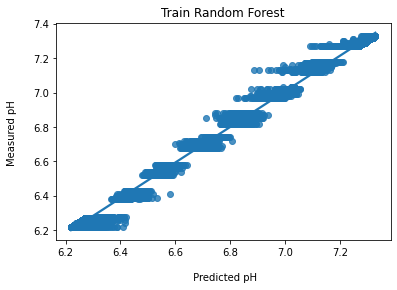

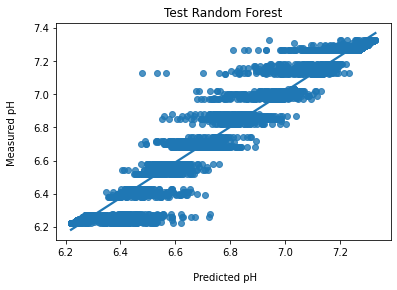

In [9]:
%%time
Xdata = acidoCEST_ML.drop( ['pH'],axis=1) 
Ydata = acidoCEST_ML.pH

reg_rf_all, _, _  = train_RFR(Xdata,Ydata)
save_and_print(reg_rf_all, name='RF_regressor_all_DATA')

#### Feature Importance

Text(0.5, 1.0, 'Feature Importance for Regression of pH \n All features were used\n')

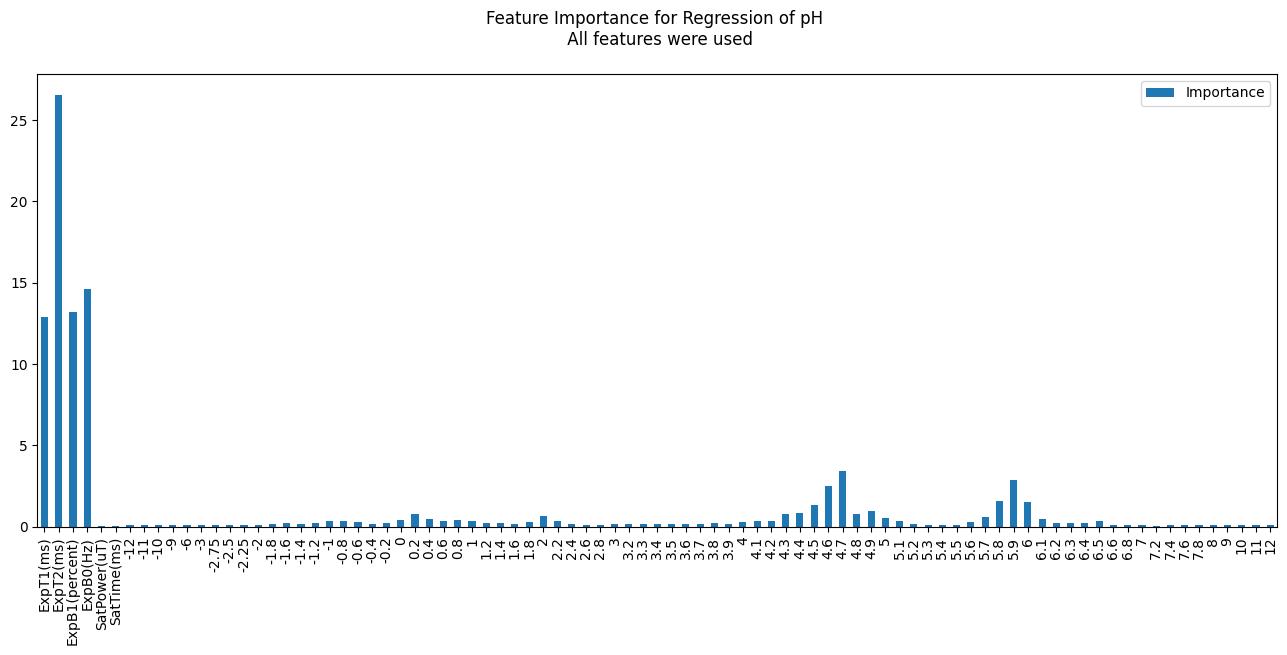

In [10]:
I = pd.DataFrame( 100 * reg_rf_all.feature_importances_, columns=['Importance'], index = Xdata.columns)
_, ax = plt.subplots(dpi = 100, figsize=(16,6))
I.plot(kind='bar', ax = ax, rot=90)
plt.title('Feature Importance for Regression of pH \n All features were used\n')

### Recursive Feature elimination

Index(['ExpT1(ms)', 'ExpT2(ms)', 'ExpB1(percent)', 'ExpB0(Hz)', '4.5', '4.6',
       '4.7', '5.8', '5.9', '6'],
      dtype='object')
------------------ Random Forest ------------------ 

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END ....max_depth=10, n_estimators=100;, score=0.768 total time=   0.6s
[CV 2/3] END ....max_depth=10, n_estimators=100;, score=0.780 total time=   0.6s
[CV 3/3] END ....max_depth=10, n_estimators=100;, score=0.769 total time=   0.6s
[CV 1/3] END ....max_depth=10, n_estimators=200;, score=0.770 total time=   1.1s
[CV 2/3] END ....max_depth=10, n_estimators=200;, score=0.783 total time=   1.1s
[CV 3/3] END ....max_depth=10, n_estimators=200;, score=0.775 total time=   1.1s
[CV 1/3] END ....max_depth=10, n_estimators=500;, score=0.766 total time=   2.7s
[CV 2/3] END ....max_depth=10, n_estimators=500;, score=0.781 total time=   2.7s
[CV 3/3] END ....max_depth=10, n_estimators=500;, score=0.779 total time=   2.5s
[CV 1/3] END ....max_d

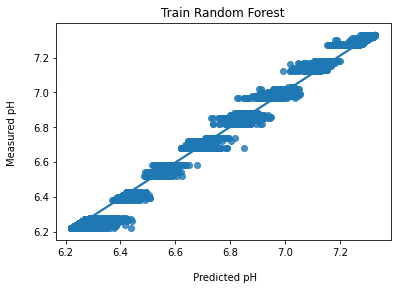

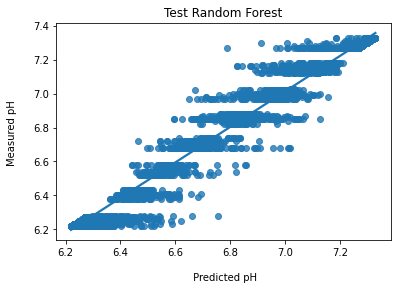

In [11]:
%%time
selected_RF = SelectFromModel( reg_rf_all  , max_features=20) 
selected_RF.fit(Xdata, Ydata)
cols = Xdata.columns[selected_RF.get_support()]

print(cols)

Xdata = acidoCEST_ML[cols]
Ydata = acidoCEST_ML.pH

reg_rf_selected_features, _, test_data_selected_features  = train_RFR(Xdata,Ydata)

save_and_print(reg_rf_selected_features, name='RF_regressor_selected')

#### Feature Importance

Text(0.5, 1.0, 'Feature Importance for Regression of pH \n All features from recursive elimination were used\n')

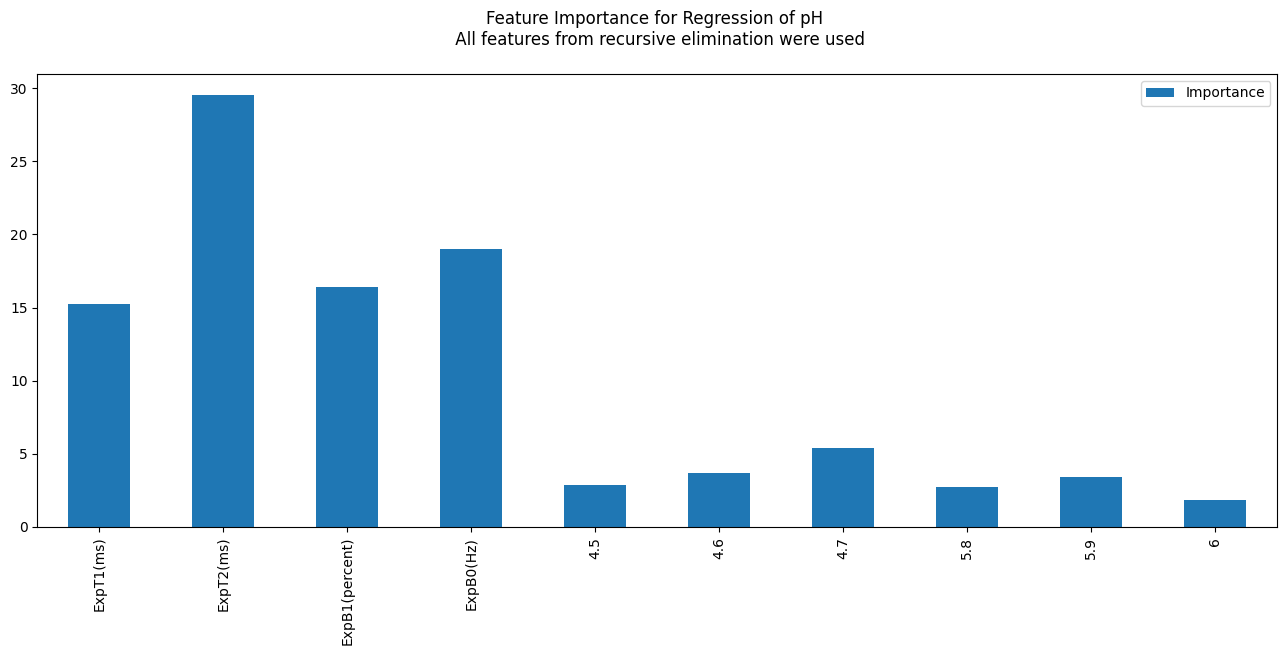

In [12]:
I = pd.DataFrame( 100 * reg_rf_selected_features.feature_importances_, columns=['Importance'], index = Xdata.columns)
_, ax = plt.subplots(dpi = 100, figsize=(16,6))
I.plot(kind='bar', ax = ax, rot=90)
plt.title('Feature Importance for Regression of pH \n All features from recursive elimination were used\n')

## Save predictions with selected

In [13]:
yhat = reg_rf_selected_features.predict( test_data_selected_features['X'] )

out = pd.DataFrame(yhat, columns=['Predicted_pH_RFReg_TEST'])
out['Measured_pH_TEST'] = test_data_selected_features['Y'].values
out.to_csv('../outputs/RF_reg_TEST_pred.csv')

out

,Predicted_pH_RFReg_TEST,Measured_pH_TEST
0,6.36566,6.28
1,7.16226,7.27
2,7.13826,7.14
3,6.25992,6.26
4,6.81954,6.87
...,...,...
5995,7.11768,7.13
5996,6.52048,6.52
5997,6.25126,6.25
5998,7.27526,7.29


## Remove B1 if selected an important feature

['ExpT1(ms)', 'ExpT2(ms)', 'ExpB0(Hz)', '4.5', '4.6', '4.7', '5.8', '5.9', '6']
------------------ Random Forest ------------------ 

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END ....max_depth=10, n_estimators=100;, score=0.769 total time=   0.6s
[CV 2/3] END ....max_depth=10, n_estimators=100;, score=0.770 total time=   0.5s
[CV 3/3] END ....max_depth=10, n_estimators=100;, score=0.776 total time=   0.5s
[CV 1/3] END ....max_depth=10, n_estimators=200;, score=0.770 total time=   1.0s
[CV 2/3] END ....max_depth=10, n_estimators=200;, score=0.774 total time=   1.0s
[CV 3/3] END ....max_depth=10, n_estimators=200;, score=0.776 total time=   1.2s
[CV 1/3] END ....max_depth=10, n_estimators=500;, score=0.767 total time=   2.6s
[CV 2/3] END ....max_depth=10, n_estimators=500;, score=0.774 total time=   2.4s
[CV 3/3] END ....max_depth=10, n_estimators=500;, score=0.778 total time=   2.5s
[CV 1/3] END ....max_depth=20, n_estimators=100;, score=0.936 total time=   

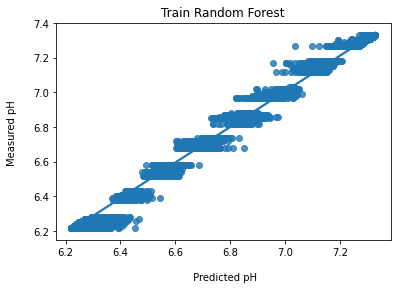

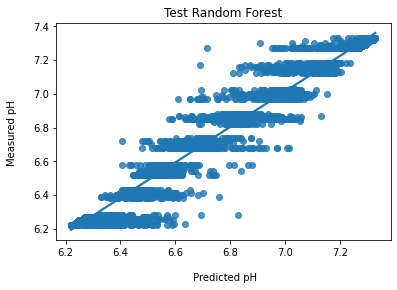

In [14]:
%%time

cols_without_B1 = [x for x in cols if 'B1' not in x ]
print(cols_without_B1)

Xdata = acidoCEST_ML[cols_without_B1]
Ydata = acidoCEST_ML.pH

reg_rf_RFE_noB1, _, _  = train_RFR(Xdata,Ydata)
save_and_print(reg_rf_RFE_noB1, name='RF_regressor_selected_no_B1')

## Effect of number of  estimators using Recursive Feature elimination features

In [ ]:
def train_RFR_02(Xdata, pH_observed):
    print('------------------ Random Forest ------------------ ')
    print()
    # grid
    param_grid = dict( n_estimators = [1,2,5,10,20,40,80,160], max_depth = [2**(x) for x in [1,2,3,4,5,6]])

    
    # grid parameters
    scorer = metrics.make_scorer( metrics.r2_score, greater_is_better = True) 
    
    #
    estimator = GridSearchCV( RFR(random_state = 42,  n_jobs = -1), param_grid, verbose = 0, cv = 10, n_jobs= 1, scoring=scorer )

    # fit
    estimator.fit(Xdata, pH_observed)

    score_train = np.round( 100 * metrics.mean_absolute_percentage_error(pH_observed , estimator.predict(Xdata)), 2)
    score_test  = np.round( 100 * metrics.mean_absolute_percentage_error(pH_observed , estimator.predict(Xdata)), 2)



    m = f' mean absolute percentage error \n train = {score_train} % \n test  = {score_test} %'
    
    print(estimator.best_estimator_)
    
    return estimator.best_estimator_, estimator

reg, CV = train_RFR_02(Xdata, Ydata)

R = pd.DataFrame()

pars = ['param_max_depth', 'param_n_estimators','std_test_score','mean_test_score']

for p in pars:
    R[p] = CV.cv_results_[p]

R['param_max_depth'] = R['param_max_depth'].astype(str) 
    
plt.figure(dpi=100)

for n  in R.param_n_estimators.unique():
    scores = R[R.param_n_estimators == n]
    plt.errorbar(x=scores['param_max_depth'], y=scores['mean_test_score'], yerr=scores['std_test_score'])
    
plt.legend([f'{x} trees' for x in R.param_n_estimators.unique()])

plt.xlabel('\n Max Depth for each tree')

plt.ylabel('Mean R2 score \n')

------------------ Random Forest ------------------ 



## Matrix Regression

In [ ]:
# Regression

def train_RFR_without_split(Xdata, pH_observed):
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(Xdata, pH_observed, test_size=0.30, random_state=42)
        
    # grid parameters
    #param_grid = dict( n_estimators = [10], max_depth =[10,40,None] )
    
    #score
    #scorer = metrics.make_scorer( metrics.r2_score, greater_is_better = True) 
    
    # fit
    #estimator = GridSearchCV( RFR(random_state = 42,  n_jobs = -1), param_grid, verbose = 0, cv = 3, n_jobs= 1, scoring=scorer )
    #estimator.fit(X_train, y_train)

    
    REG = RFR(random_state = 42,  n_jobs = -1, n_estimators=500, max_depth=None).fit(X_train, y_train)
    
    #REG = estimator.best_estimator_
        
        
    train_e = np.round( 100 * metrics.mean_absolute_percentage_error(y_train, REG.predict(X_train)),2 )
    
    test_e  = np.round( 100 * metrics.mean_absolute_percentage_error(y_test, REG.predict(X_test)),2 )
    return train_e, test_e

def matrix(FEATURES):
    powers = acidoCEST_ML['SatPower(uT)'].unique()
    times = acidoCEST_ML['SatTime(ms)'].unique()
    
    train_results = []
    test_results = []
    
    for p in powers:
        for s in times:
            filt = (acidoCEST_ML['SatPower(uT)'] == p) & (acidoCEST_ML['SatTime(ms)']  == s)
            e1, e2 = train_RFR_without_split(acidoCEST_ML[FEATURES][filt], acidoCEST_ML['pH'][filt])
            train_results.append((p,s,e1))
            test_results.append((p,s,e2))
    
    M_train = pd.DataFrame(train_results,columns=['Sat Power (uT)','Sat Time (ms)','Error']).pivot(index='Sat Power (uT)', columns='Sat Time (ms)', values='Error') 
    M_test = pd.DataFrame(test_results,columns=['Sat Power (uT)','Sat Time (ms)','Error']).pivot(index='Sat Power (uT)', columns='Sat Time (ms)', values='Error')
    return M_train, M_test
    

### 4.2 and 5.6

In [ ]:
M1_train, M1_test  = matrix(FEATURES = ['4.2','5.6'])

In [ ]:
_ , axs = plt.subplots(dpi=100,ncols=2, figsize=(16,8) )
sns.heatmap( M1_train.sort_values('Sat Power (uT)',ascending=False) ,linewidths=1, annot=True, vmin= 2, vmax= 5.0,ax =axs[0], cmap='jet')
sns.heatmap( M1_test.sort_values('Sat Power (uT)',ascending=False) ,linewidths=1, annot=True, vmin= 2, vmax= 5.0,ax =axs[1], cmap='jet')
#plt.title('Mean absolute error (%) for regression of pH \n 4.2 and 5.6 ppm ')

### All CEST

In [ ]:
M2_train, M2_test = matrix(FEATURES = acidoCEST_ML.columns[7::] )

In [ ]:
_ , axs = plt.subplots(dpi=100,ncols=2, figsize=(16,8) )
sns.heatmap( M2_train.sort_values('Sat Power (uT)',ascending=False) ,linewidths=1, annot=True, vmin= 2, vmax= 5.0,ax =axs[0], cmap='jet')
sns.heatmap( M2_test.sort_values('Sat Power (uT)',ascending=False) ,linewidths=1, annot=True, vmin= 2, vmax= 5.0,ax =axs[1], cmap='jet')
#plt.title('Mean absolute error (%) for regression of pH \n 4.2 and 5.6 ppm ')

### All data

In [ ]:
all_features = list(acidoCEST_ML.drop(['pH'],axis=1).columns)
M3_train, M3_test = matrix(FEATURES = all_features )

In [ ]:
_ , axs = plt.subplots(dpi=100,ncols=2, figsize=(16,8) )
sns.heatmap( M3_train.sort_values('Sat Power (uT)',ascending=False) ,linewidths=1, annot=True, vmin= 2, vmax= 5.0,ax =axs[0], cmap='jet')
sns.heatmap( M3_test.sort_values('Sat Power (uT)',ascending=False) ,linewidths=1, annot=True, vmin= 2, vmax= 5.0,ax =axs[1], cmap='jet')
# plt.title('Mean absolute error (%) for regression of pH \n All features')

### Applying model outside the ranges of Sat power and Sat time used for training

In [ ]:
cest_cols = list(acidoCEST_ML.columns[7::])
power = 3.0
time =  3000

filt = (acidoCEST_ML['SatPower(uT)'] == 3.0) & (acidoCEST_ML['SatTime(ms)'] == 3000)
REG = RFR(random_state = 42,  n_jobs = -1, n_estimators=500, max_depth=None).fit(acidoCEST_ML[filt][cest_cols], acidoCEST_ML.pH[filt])

powers = acidoCEST_ML['SatPower(uT)'].unique()
times = acidoCEST_ML['SatTime(ms)'].unique()

Q = []
for p in powers:
    for s in times:
        filt   = (acidoCEST_ML['SatPower(uT)'] == p) & (acidoCEST_ML['SatTime(ms)']  == s)
        y_hat  = REG.predict(acidoCEST_ML[filt][cest_cols])
        y_true = acidoCEST_ML[filt]['pH']
        
        e = np.round( metrics.r2_score(y_true, y_hat),2 )
        Q.append((p,s,e))

MQ = pd.DataFrame(Q,columns=['Sat Power (uT)','Sat Time (ms)','r2_score']).pivot(index='Sat Power (uT)', columns='Sat Time (ms)', values='r2_score')   

In [ ]:
_, ax = plt.subplots(dpi=100)
sns.heatmap( MQ.sort_values('Sat Power (uT)',ascending=False) ,linewidths=1, annot=True,  cmap='Set1',ax=ax, vmin=-1 , vmax=1)
plt.title('R2 score for pH regression \n \n The model was trained with all data at 3.0 sec and 3.0 uT \n')

### Training model and a small sample of all data -- > Applying model to rest of data

In [ ]:
cest_cols = list(acidoCEST_ML.columns[7::])
train, test = train_test_split(acidoCEST_ML, test_size=.70)

REG = RFR(random_state = 42,  n_jobs = -1, n_estimators=500, max_depth=None).fit(train[cest_cols], train.pH)

powers = acidoCEST_ML['SatPower(uT)'].unique()
times = acidoCEST_ML['SatTime(ms)'].unique()

Q2 = []
for p in powers:
    for s in times:
        filt   = (test['SatPower(uT)'] == p) & (test['SatTime(ms)']  == s)
        y_hat  = REG.predict(test[filt][cest_cols])
        y_true = test[filt]['pH']
        
        e = np.round( metrics.r2_score(y_true, y_hat),2 )
        Q2.append((p,s,e))

MQ2 = pd.DataFrame(Q2,columns=['Sat Power (uT)','Sat Time (ms)','r2_score']).pivot(index='Sat Power (uT)', columns='Sat Time (ms)', values='r2_score')   

In [ ]:
_, ax = plt.subplots(dpi=100)
sns.heatmap( MQ2.sort_values('Sat Power (uT)',ascending=False) ,linewidths=1, annot=True,  cmap='Set1',ax=ax, vmin=-1 , vmax=1)
plt.title('R2 score for pH regression \n \n The model was trained with 30% of all data \n')